# <img style="float: left; padding-right: 10px; width: 45px" src="https://github.com/Harvard-IACS/2021-s109a/blob/master/lectures/crest.png?raw=true"> CS-S109A Introduction to Data Science 

## Homework 4:  Logistic Regression and PCA

**Harvard University**<br/>
**Summer 2021**<br/>
**Instructors**: Kevin Rader


<hr style='height:2px'>

---



In [1]:
## RUN THIS CELL TO GET THE RIGHT FORMATTING 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited. 

In [2]:
import numpy as np
import pandas as pd
import sklearn as sk

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.decomposition import PCA

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import zipfile


import seaborn as sns
sns.set()

# if you want to do a 2-sample t-test:
from scipy.stats import ttest_ind

<div class='theme'> Cancer Classification from Gene Expressions </div>

In this problem, we will build a classification model to distinguish between two related classes of cancer, acute lymphoblastic leukemia (ALL) and acute myeloid leukemia (AML), using gene expression measurements. The dataset is provided in the file `data/genomic_data.csv`. Each row in this file corresponds to a tumor tissue sample from a patient with one of the two forms of Leukemia. The first column contains the cancer type, with **0 indicating the ALL** class and **1 indicating the AML** class. Columns 2-7130 contain expression levels of 7129 genes recorded from each tissue sample. 

In the following questions, we will use linear and logistic regression to build classification models for this data set. 


<div class='exercise'><b> Question 1 [15 pts]: Data Exploration </b></div>

The first step is to split the observations into an approximate 75-25 train-test split.  Below is some code to do this for you (we want to make sure everyone has the same splits). It also prints the dataset's shape before splitting and after splitting. `Cancer_type` is our target column.


**1.1** Take a peek at your training set: you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands). To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1. **NOTE: for the entirety of this homework assignment, you will use these normalized values, not the original, raw values**. Normalizing genomic data is a fairly standard first step.


**1.2** The training set contains more predictors than observations. What problem(s) can this lead to in fitting a classification model to such a dataset? Explain in 3 or fewer sentences.


**1.3** Determine which single gene individually discriminates between the two cancer classes the best (consider every gene in the dataset) and call it `best_predictor`.

Plot two histograms of your `best_predictor` -- one using the training set and another using the testing set. The histogram should clearly distinguish two different `Cancer_type` classes.

**Hint:** You may use any reasonable approach to determine the `best_predictor`, but please use something very simple (whether taught in this class or elsewhere).


**1.4** Using `best_predictor`, create a classification model by simply eye-balling a value for this gene that would discriminate the two classes the best (do not use an algorithm to determine for you the optimal coefficient or threshold; we are asking you to provide a rough estimate / model by manual inspection). Justify your choice in 1-2 sentences. Report the accuracy of your hand-chosen model on the test set.

<hr> 


### Answers

**The first step is to split the observations into an approximate 75-25 train-test split. Below is some code to do this for you (we want to make sure everyone has the same splits). Print dataset shape before splitting and after splitting. `Cancer_type` is our target column.**

In [3]:
np.random.seed(10)
df = pd.read_csv('data/genomic_data.csv', index_col=0)
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'Cancer_type'], 
                                                         df.Cancer_type, test_size=0.25, 
                                                         random_state = 109, 
                                                         stratify = df.Cancer_type)

In [4]:
print('shape of full set:', df.shape)
print('shape of x_train:', X_train.shape,'\nshape of x_test:',X_test.shape,'\nshape of y_train:', y_train.shape,'\nshape of y_test:', y_test.shape)
print('value count of dataset: \n', df.Cancer_type.value_counts(normalize=True))

shape of full set: (752, 7130)
shape of x_train: (564, 7129) 
shape of x_test: (188, 7129) 
shape of y_train: (564,) 
shape of y_test: (188,)
value count of dataset: 
 0.0    0.511968
1.0    0.488032
Name: Cancer_type, dtype: float64


**1.1 Take a peek at your training set: you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands). To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1. **NOTE: for the entirety of this homework assignment, you will use these normalized values, not the original, raw values.**


In [5]:
# X_train.describe()

In [6]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()
# scaler = scaler.fit(X_train)
dfNorm = scaler.fit_transform(df)
dfNorm = pd.DataFrame(dfNorm, columns = df.columns, index = df.index)
X_trainNorm = scaler.fit_transform(X_train)
X_trainNorm = pd.DataFrame(X_trainNorm, columns = X_train.columns, index = X_train.index)
X_testNorm = scaler.fit_transform(X_test)
X_testNorm = pd.DataFrame(X_testNorm, columns = X_test.columns, index = X_test.index)
dfNorm

,Cancer_type,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,0.0,0.482348,0.636828,0.421504,0.354724,0.541964,0.313961,0.656215,0.557102,0.751598,...,0.577873,0.430681,0.346731,0.386057,0.611047,0.499519,0.370208,0.549853,0.470914,0.434172
1,0.0,0.538320,0.663173,0.653266,0.302249,0.463755,0.298072,0.644340,0.479530,0.602312,...,0.624184,0.522397,0.715986,0.349330,0.498395,0.471359,0.310147,0.387588,0.460523,0.317450
2,0.0,0.558867,0.655742,0.408589,0.409961,0.582961,0.475211,0.599733,0.611503,0.617755,...,0.553454,0.469745,0.542662,0.405702,0.628022,0.407405,0.364542,0.508344,0.449332,0.460110
3,0.0,0.582957,0.642908,0.633893,0.331939,0.476370,0.318081,0.636519,0.554080,0.658937,...,0.447358,0.517868,0.289674,0.345401,0.640367,0.558384,0.428003,0.500796,0.499371,0.423364
4,0.0,0.341354,0.564548,0.468144,0.292583,0.386808,0.177429,0.518919,0.267971,0.617755,...,0.665444,0.464084,0.388716,0.371196,0.703637,0.670006,0.414405,0.593250,0.565236,0.557378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747,0.0,0.696528,0.584498,0.379790,0.437056,0.422404,0.294715,0.631741,0.330545,0.747420,...,0.560462,0.651464,0.435819,0.311584,0.508865,0.516085,0.323915,0.654308,0.857588,0.324064
748,1.0,0.640335,0.709007,0.145601,0.640275,0.543410,0.819101,0.498926,0.753030,0.840198,...,0.793460,0.295969,0.402568,0.676392,0.560715,0.575147,0.336958,0.699631,0.752875,0.557553
749,1.0,0.519750,0.459566,0.198037,0.314083,0.582719,0.369624,0.658192,0.444315,1.000000,...,0.506640,0.212257,0.585057,0.331757,0.773867,0.800121,0.176060,0.352877,0.379286,0.726550
750,0.0,0.622598,0.732820,0.621132,0.303219,0.065618,0.375281,0.557282,0.373386,0.490326,...,0.559916,0.536638,0.238878,0.297934,0.806955,0.564062,0.510765,0.436667,0.348156,0.405826


**1.2 The training set contains more predictors than observations. What problem(s) can this lead to in fitting a classification model to such a dataset? Explain in 3 or fewer sentences.**

#### Answer 1.2.:
When p > n we obtain perfect collinearity of the predictor set, and our model is susceptible to overfitting. 
Other problems that can arise with high dimentionality are that matrices may not be invertible (issue in OLS).


**1.3 Determine which single gene individually discriminates between the two cancer classes the best (consider every gene in the dataset) and call it `best_predictor`.**

**Plot two histograms of your `best_predictor` -- one using the training set and another using the testing set. The histogram should clearly distinguish two different `Cancer_type` classes.**

In [7]:
# Calculating highest accuracy score from using single predictor log regression on each gene.

list_of_scores= []
for row in np.arange(len(y_test)):
    logit1 = LogisticRegression(penalty="none", fit_intercept=True).fit(X_trainNorm.iloc[:,row].values.reshape(-1,1), y_train)
    list_of_scores.append(accuracy_score(y_test, logit1.predict(X_testNorm.iloc[:,row].values.reshape(-1,1))))

best_predictor = X_testNorm.columns[np.argmax(list_of_scores)]
print('The gene that provides the highest score is {0} with a an accuracy score of {1:.4f}'.format(best_predictor,np.max(list_of_scores)))                     

The gene that provides the highest score is AFFX-BioC-5_st with a an accuracy score of 0.6702


In [8]:
# splitting the values into the ones that are predicted to be ALL and AML respectively:
best_pred_ALL=[]
best_pred_AML=[]
# slett en av disse linjene: logit1 = LogisticRegression(penalty="none", fit_intercept=True).fit(X_trainNorm, y_train)
logit1 = LogisticRegression(penalty="none", fit_intercept=True).fit(X_trainNorm.loc[:,best_predictor].values.reshape(-1,1), y_train)
for indeks, row in enumerate(X_trainNorm[best_predictor]):
    if (1-int(logit1.predict(X_trainNorm.loc[X_trainNorm.index[indeks], best_predictor].reshape(-1,1)))) == 0:
        best_pred_ALL.append(row)
    else:
        best_pred_AML.append(row)
# same for test        
best_pred_ALL_test=[]
best_pred_AML_test=[]
for indeks, row in enumerate(X_testNorm[best_predictor]):
    if (1-int(logit1.predict(X_testNorm.loc[X_testNorm.index[indeks], best_predictor].reshape(-1,1)))) == 0:
        best_pred_ALL_test.append(row)
    else:
        best_pred_AML_test.append(row)
# best_pred_ALL

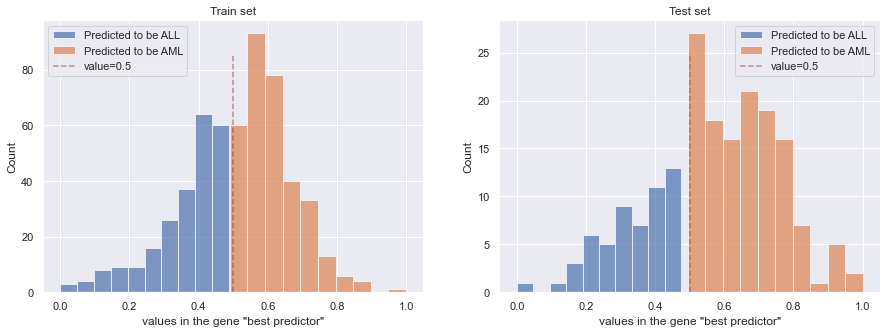

In [9]:
# plt.hist(X_trainNorm[best_predictor], alpha=0.7, label='Train set')
fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].hist(best_pred_ALL, alpha=0.7, label='Predicted to be ALL', bins=10)
ax[0].hist(best_pred_AML, alpha=0.7, label='Predicted to be AML', bins=10)
ax[0].vlines(0.5,ymin=0,ymax=85, linestyle='--',color='brown',alpha=0.5, label='value=0.5')
ax[0].set_xlabel('values in the gene \"best predictor\"')
ax[0].set_ylabel('Count')
ax[0].set_title('Train set')
ax[0].legend()

ax[1].hist(best_pred_ALL_test, alpha=0.7, label='Predicted to be ALL', bins=10)
ax[1].hist(best_pred_AML_test, alpha=0.7, label='Predicted to be AML', bins=10)
ax[1].set_xlabel('values in the gene \"best predictor\"')
ax[1].vlines(0.5,ymin=0,ymax=25, linestyle='--',color='brown',alpha=0.5, label='value=0.5')
ax[1].set_ylabel('Count')
ax[1].set_title('Test set')
ax[1].legend()

plt.show()

#So they are asking us to clearly distinguish between the two classes of cancer, in which we will..
# have to make a prediction on a model. In this case I have used the logit1 we fit against..
# each of the single predictors separately. Not sure if this correct looking at the gap in the plot..

**1.4 Using `best_predictor`, create a classification model by simply eye-balling a value for this gene that would discriminate the two classes the best (do not use an algorithm to determine for you the optimal coefficient or threshold; we are asking you to provide a rough estimate / model by manual inspection). Justify your choice in 1-2 sentences. Report the accuracy of your hand-chosen model on the test set.**


In [10]:
# fix
X_testNorm.loc[X_testNorm.index[116],best_predictor]
np.argmax(X_testNorm[best_predictor])

print('''
The highest value from best_predictor is observation number 116 which is 1 on the standardized scale.
''')



The highest value from best_predictor is observation number 116 which is 1 on the standardized scale.



*your answer here*

---

<div class='exercise'> <b> Question 2 [35pts]: Logistic Regression Modeling </b> </div>


**2.1** Fit a simple logistic regression model to the training set using the single gene predictor `best_predictor` to predict cancer type.  Carefully interpret the coefficient estimates for this model.

*Remember, you need to set the regularization parameter for sklearn's logistic regression function to be a very large value in order to **not** regularize (use `C=100000` or `penalty = "none"`).

**2.2** Plot the logistic curves for the model in 2.1 ($y$-axis is probability scale, $x$-axis is `best_predictor`).  Interpret this plot: at what values of your `best_predictor` will you predict the patient to have ALL?  How does this compare to your eeballed value from 1.4?

**2.3** Calculate the training and test classification accuracies of this model in 2.1. How do these compare to the eye-balled model from 1.4?


**2.4** Next, fit a multiple logistic regression model with **all** the gene predictors from the data set (reminder: for this assignment, we are always using the normalized values). How does the classification accuracy of this model compare with the models fitted with a single gene (on both the training and test sets)?  

**2.5** Print out and interpret the logistic regression coefficients for  `best_predictor` from both the simple logistic and multiple logistic regression models from the previous two parts.  Do they agree or disagree?  What does this indicate?

**2.6** Now let's use regularization to improve the predictions from the multiple logistic regression model. Specifically, use LASSO-like regularization and 5-fold cross-validation to fit the model on the training set (choose between 20 reasonable values of $\lambda$). Report the classification accuracy on both the training and testing set.

**2.7** How many predictors are considered as important features in this regularized model?  What does that say about the full logistic regression model in problem 2.4?


## Answers

**2.1 Fit a simple logistic regression model to the training set using the single gene predictor `best_predictor` to predict cancer type. Carefully interpret the coefficient estimates for this model.**

In [11]:
logit = LogisticRegression(penalty="none", fit_intercept=True)
logit_single = logit.fit(X_trainNorm[best_predictor].values.reshape(-1, 1), y_train)
print('The intercept for the single reg model is: ', logit_single.intercept_[0], '. This means that the log odds for type of cancer are ~1.27 when x=0, i.e. when this gene has its lowest value (since the values are normalizaed).')
print('The coefficiant for the single reg model is: ', logit_single.coef_[0][0], '. This means that the log odds for type of cancer decreases with ~2.59 when x goes from 0 to 1, i.e when this gene has the highest observed value rather than the lowest.')

The intercept for the single reg model is:  1.2684248229969208 . This means that the log odds for type of cancer are ~1.27 when x=0, i.e. when this gene has its lowest value (since the values are normalizaed).
The coefficiant for the single reg model is:  -2.5937379099642888 . This means that the log odds for type of cancer decreases with ~2.59 when x goes from 0 to 1, i.e when this gene has the highest observed value rather than the lowest.


*your answer here* 


**2.2 Plot the logistic curves for the model in 2.1 ($y$-axis is probability scale, $x$-axis is `best_predictor`).  Interpret this plot: at what values of your `best_predictor` will you predict the patient to have ALL?  How does this compare to your eeballed value from 1.4?**


In [12]:
# slett: X_dummy = np.linspace(np.min(X_testNorm[best_predictor]),np.max(X_testNorm[best_predictor]))
classification_boundary = -(logit_single.intercept_[0])/logit_single.coef_[0][0]

X_trainNorm_sorted = np.sort(X_trainNorm[best_predictor])
X_testNorm_sorted = np.sort(X_testNorm[best_predictor])
y_pred_single_train = logit_single.predict(X_trainNorm_sorted.reshape(-1, 1))
y_pred_single_test = logit_single.predict(X_testNorm_sorted.reshape(-1, 1))
y_predproba_single_train = logit_single.predict_proba(X_trainNorm_sorted.reshape(-1, 1))[:,0]
y_predproba_single_test = logit_single.predict_proba(X_testNorm_sorted.reshape(-1, 1))[:,0]

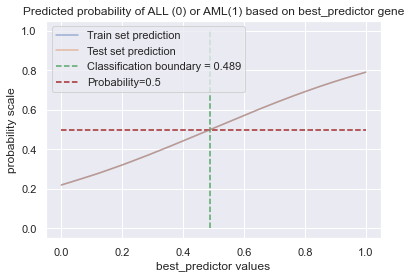

Since the classification boundary is 0.489,the model will predict patients to have ALL for all scores below this value, and AML for all scores above.


In [13]:
# Plot:

plt.plot(X_testNorm_sorted, y_predproba_single_test, label='Train set prediction', alpha=0.5)
plt.plot(X_trainNorm_sorted, y_predproba_single_train, label='Test set prediction', alpha=0.5)
plt.vlines(classification_boundary,ymin=np.min(X_testNorm_sorted),ymax=np.max(X_testNorm_sorted), linestyles='--', color='g', label='Classification boundary = {:.3f}'.format(classification_boundary))
plt.hlines(0.5,xmin=np.min(X_testNorm_sorted),xmax=np.max(X_testNorm_sorted), linestyles='--', color='brown',label='Probability=0.5')
plt.xlabel('best_predictor values')
plt.ylabel('probability scale')
plt.title('Predicted probability of ALL (0) or AML(1) based on best_predictor gene')
plt.legend()
plt.show()

print('Since the classification boundary is {:.3f},the model will predict patients to have ALL for all scores below this value, and AML for all scores above.'.format(classification_boundary))

**2.3 Calculate the training and test classification accuracies of this model in 2.1.  How do these compare to the eye-balled model from 1.4?**

In [14]:
print('The accurracy for the train set it:', logit_single.score(X_trainNorm[best_predictor].values.reshape(-1,1),y_train))
print('The accurracy for the test set it:', logit_single.score(X_testNorm[best_predictor].values.reshape(-1,1),y_test))

# print(' They compare to the eye-balled model ......')  
#         #fix

The accurracy for the train set it: 0.601063829787234
The accurracy for the test set it: 0.6702127659574468


*your answer here* 


**2.4 Next, fit a multiple logistic regression model with *all* the gene predictors from the data set (reminder: for this assignment, we are always using the normalized values). How does the classification accuracy of this model compare with the models fitted with a single gene (on both the training and test sets)?**


In [15]:
logit = LogisticRegression(penalty="none", fit_intercept=True)
logit_multiple = logit.fit(X_trainNorm.values.reshape(-1, 7129), y_train)
y_pred_multiple_train = logit_multiple.predict(X_trainNorm)
y_pred_multiple_test = logit_multiple.predict(X_testNorm) 

    
print('The accurracy for the mutliple regression train set it:', logit_multiple.score(X_trainNorm,y_train))
print('The accurracy for the mutliple regression test set it: {:.4f}'.format(logit_multiple.score(X_testNorm,y_test)))

print('For comparison the accurracy for the single predictor was {0:.4f} for train and {1:.4f} for test. \nWe see that this model does better on the test score, even though it is clearly overfit on the train'.format(accuracy_score(y_train, logit_single.predict(X_trainNorm.loc[:,best_predictor].values.reshape(-1,1))), np.max(list_of_scores)))


The accurracy for the mutliple regression train set it: 1.0
The accurracy for the mutliple regression test set it: 0.7766
For comparison the accurracy for the single predictor was 0.6011 for train and 0.6702 for test. 
We see that this model does better on the test score, even though it is clearly overfit on the train


##### Answer 2.4:
As we would expect we get an R-squared of 1 for our train-set when we have more predictors than observations. This is clearly overfit, and we get an R-squared of 0.106 the test set. This is much worse than our single predictor model for our best predictor, which got an R^2 score of 0.670 for train and 0.601 for train.

**2.5 Print out and interpret the logistic regression coefficients for `best_predictor` from both the simple logistic and multiple logistic regression models from the previous two parts.  Do they agree or disagree?  What does this indicate?**

In [16]:
# print(logit_multiple.coef_[0])
print('The coefficient for best_predictor for the multiple regression model is:', logit_multiple.coef_[0][X_trainNorm.columns.tolist().index(best_predictor)], ' \nThis negative coefficient means that a higher value of this predictor indicates a higher probability of having ALL rather than AML (0 rather than 1 in the response)')
print('\nThe coefficient for the single reg model is: ', logit_single.coef_[0][0], '. The reason this coefficien is higher is probably caused by omitted variable bias occurring when the single predictor model is attributing the effect of variables that were ommitted to our best_predictor variable.') 

#delete this:
# print('\nThe intercept for the multiple regression model is:', logit_multiple.intercept_[0], '.\nThis defines the log odds for type of cancer when x=0, i.e. when this gene has its lowest value (since the values are normalizaed).')
# print('\nThe intercept for the single reg model is: ', logit_single.intercept_[0],  ' and is individually interpreted in task 2.1.') 

The coefficient for best_predictor for the multiple regression model is: -1.8751379379201865  
This negative coefficient means that a higher value of this predictor indicates a higher probability of having ALL rather than AML (0 rather than 1 in the response)

The coefficient for the single reg model is:  -2.5937379099642888 . The reason this coefficien is higher is probably caused by omitted variable bias occurring when the single predictor model is attributing the effect of variables that were ommitted to our best_predictor variable.


**2.6 Now let's use regularization to improve the predictions from the multiple logistic regression model. Specifically, use LASSO-like regularization and 5-fold cross-validation to fit the model on the training set (choose between 20 reasonable values of $\lambda$). Report the classification accuracy on both the training and testing set.**

In [17]:
# from sklearn.linear_model import LogisticRegressionCV
# heia=LogisticRegressionCV(Cs=np.linspace(1,1000,20))
# heia.fit(X_trainNorm, y_train)

In [18]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
lambdas = [1,2]#np.logspace(-1,8,20)


def cv_optimize_Lasso(x: np.ndarray, y: np.ndarray, list_of_lambdas: list, n_folds: int = 5):
    parameters = {'alpha': list_of_lambdas}
    # the scoring parameter below is the default one in ridge, but you can use a different one in the cross-validation phase if you want.
    gs = GridSearchCV(Lasso(), param_grid=parameters, cv=n_folds, scoring="accuracy")
    gs.fit(x, y)
    return gs

lasso_train = cv_optimize_Lasso(X_trainNorm, y_train, lambdas)
lasso_test = cv_optimize_Lasso(X_testNorm, y_test, lambdas)

print('Best training set Score (average of the 5 folds)): ', lasso_train.best_score_)
print('Best training set Params: ', lasso_train.best_params_)
print('Best test set Score (average of the 5 folds): ', lasso_test.best_score_)
print('Best test set Params: ', lasso_test.best_params_)

# Best training set Score (average of the 5 folds)):  0.5935600237992562
# Best training set Params:  {'alpha': 0.00379269019073225}
# Best test set Score (average of the 5 folds):  0.3451886036275259
# Best test set Params:  {'alpha': 0.00379269019073225}

C:\Users\krist\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\krist\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\krist\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\krist\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\krist\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\krist\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, 

C:\Users\krist\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\krist\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\krist\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\krist\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\krist\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\krist\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, 

C:\Users\krist\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\krist\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\krist\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\krist\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\krist\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\krist\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, 

Best training set Score (average of the 5 folds)):  nan
Best training set Params:  {'alpha': 1}
Best test set Score (average of the 5 folds):  nan
Best test set Params:  {'alpha': 1}


C:\Users\krist\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\krist\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\krist\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\Users\krist\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\krist\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\krist\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, 

**2.7 How many predictors are considered as important features in this regularized model?  What does that say about the full logistic regression model in problem 2.4?**


In [19]:
lasso_reg = Lasso(alpha= 0.00379269019073225)
lasso_reg.fit(X_trainNorm, y_train)

print('Training set Score: ', lasso_reg.score(X_trainNorm,y_train))
print('Test set Score: ', lasso_reg.score(X_testNorm,y_test))

# Making a list of all coefficients that have not been shrinked to 0:
coef_list = []
for value in lasso_reg.coef_.tolist():
    if value != 0:
        coef_list.append(value)
print('Number of coefficiants that have not been shrinked to zero:',len(coef_list))

Training set Score:  0.7340151757879942
Test set Score:  0.4006241929728108
Number of coefficiants that have not been shrinked to zero: 107


##### Answer 2.7:
We see that the number of important features has been shrinked from 7129 to 107. We also see that we were correct about the overfitting of the model including all predictors, and that the model is doing much better at prediction with this subset of predictors.

---

<div class='exercise'> <b> Question 3 [10pts]: $k$-NN Classification </b> </div>

**3.1** Use 5-fold cross-validation to select $k$ for a $k$-NN classification model based on the full predictor set.  Choose between `ks = [1,3,5,7,10,15,20,50,100]`. 

**3.2** Provide the confusion matrix for 3 models: (i) the full multiple logistic regression model from 2.4, (ii) the best regularized model from 2.6, and (iii) the best $k$-NN from the previous part. Report the false positive and false negative rates (all in the test set).  Briefly interpret what you notice.


### Answers

**3.1 Use 5-fold cross-validation to select $k$ for a $k$-NN classification model based on the full predictor set.  Choose between `ks = [1,3,5,7,10,15,20,50,100]`.  Report your chosen $k$, and report the misclassification rate on both the train and test sets for the model using your chosen $k$.**

In [20]:
from sklearn.model_selection import KFold
n_folds = 5  #antallet folds du vil ha
kfold = KFold(n_folds, shuffle=True)
ks = [1,3,5,7,10,15,20,50,100]
#list(kfold.split(range(48)))

score_list = [[],[],[],[],[],[],[],[],[]]
for i,k in enumerate(ks):
    fittedModel = KNeighborsClassifier(n_neighbors=k).fit(X_trainNorm, y_train)
    score_list[i].append(k)
    score_list[i].append(fittedModel.score(X_testNorm,y_test))
    
score_df = pd.DataFrame(score_list, columns=['k-value','accurracy score'])
display(score_df)
print('The best k-NN model is when k=5 and k=7 as they are identical in those two situations.')
print('Selecting k={} for my model'.format(score_df['k-value'][np.argmax(score_df['accurracy score'])]))

print('Score for k=5:', score_df['accurracy score'][2])
print('Score for k=7:', score_df['accurracy score'][3])

,k-value,accurracy score
0,1,0.771277
1,3,0.819149
2,5,0.861702
3,7,0.861702
4,10,0.851064
5,15,0.845745
6,20,0.787234
7,50,0.712766
8,100,0.601064


The best k-NN model is when k=5 and k=7 as they are identical in those two situations.
Selecting k=5 for my model
Score for k=5: 0.8617021276595744
Score for k=7: 0.8617021276595744


In [21]:
# The misclassification rate for k = 5 is (1-accuracy rate):

fittedModel_5 = KNeighborsClassifier(n_neighbors=5).fit(X_trainNorm, y_train)
print("Overall misclassification rate in train:",1-fittedModel_5.score(X_trainNorm,y_train))
print("Overall misclassification rate in test:",1-fittedModel_5.score(X_testNorm,y_test))


Overall misclassification rate in train: 0.099290780141844
Overall misclassification rate in test: 0.13829787234042556


**3.2 Provide the confusion matrix for 3 models: (i) the full multiple logistic regression model from 2.4, (ii) the best regularized model from 2.6, and (iii) the best $k$-NN from the previous part. what are the  false positive and false negative rates in these 3 models (all in the test set)?  Briefly interpret what you notice.**

In [22]:
from sklearn.metrics import confusion_matrix
conf_knn5 = confusion_matrix(y_test, fittedModel_5.predict(X_testNorm)>0.5)  
conf_multi = confusion_matrix(y_test, logit_multiple.predict(X_testNorm)>0.5)  
# er 0.5 riktig?
# need to add for the lasso-reduced model when that is finished

print('The confusion matrix for the k-NN model with k=5: \n',conf_knn5)
print('The confusion matrix for the multiple regression model with all 7129 predictors: \n',conf_multi)

The confusion matrix for the k-NN model with k=5: 
 [[84 12]
 [14 78]]
The confusion matrix for the multiple regression model with all 7129 predictors: 
 [[83 13]
 [29 63]]


The false positive rates in these models are the upper right values of the matrix and the false negative are down to the left. See overview of these scores in the list below.
Interpretation:..

In [23]:
list_false = [[conf_knn5[0][1], conf_multi[0][1]],[conf_knn5[1][0], conf_multi[1][0]]]
pd.DataFrame(list_false, index=['False positive','False negative'], columns=['k-NN','All predictors'])


,k-NN,All predictors
False positive,12,13
False negative,14,29


---

#### <div class='exercise'><b> Question 4 [15 pts]: Performing Principal Components Analysis </b></div>

**4.1** Create the full PCA decomposition of `X_train` and apply the transformation to both `X_train` and `X_test`.  Report the shape of both of these.  What is the limiting factor for the maximum number of PCA components for this data set? 

*Hint: be sure to standardize before performing PCA.

**4.2** PCA is often solely used to help in visualizing high-dimensional problems.  Plot the scatterplot of the second PCA vector of train on the $Y$-axis and the first PCA vector of train on the $X$-axis (be sure to denote the classes via different colors and markings).  In 2-3 sentences, explain why using the scatterplot of the top 2 PCA vectors is a useful approach to visualize a high dimensional classification problem.

**4.3** Determine and report the variance explained in `X_train` based on the top 2 PCA vectors.  Determine and report how many PCA vectors are needed so that 90\% of the variability in the predictors is explained, and create a plot to illustrate this result (Hint: look at cumulative explained variability vs. number of PCA components used).  Select a reasonable value for the number of components that balances representativeness (of the predictors) with parsimony. 



### Answers

**4.1 Create the full PCA decomposition of X_train and apply the transformation to both X_train and X_test. Report the shape of both of these. What is the limiting factor for the maximum number of PCA components for this data set?**

In [50]:
# Standardize (rather than normalize):
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train) 
X_trainStd = scaler.transform(X_train) 
X_trainStd = pd.DataFrame(X_trainStd, columns = X_train.columns, index = X_train.index) 
X_testStd = scaler.transform(X_test) 
X_testStd = pd.DataFrame(X_testStd, columns = X_test.columns, index = X_test.index) 

# create/fit the 'full' pca transformation
pca = PCA().fit(X_trainStd)
# apply the pca transformation to the full predictor set
pcaTrain = pca.transform(X_trainStd)
pcaTest = pca.transform(X_testStd)
print('The shape of pcaTrain is {}'.format(pcaTrain.shape))
print('The shape of pcaTest is {}'.format(pcaTest.shape))
pcaTrain_df = pd.DataFrame(pcaTrain)

The shape of pcaTrain is (564, 564)
The shape of pcaTest is (188, 564)


##### Answer 4.1:
The limiting factor for the number of PCA components is number of observations in the data set that we fit the pca transformer to. This creates a set of components (eigen-vectors) that use our data sets to create new \"predictors\" ranging for strongest to weaker. In our case we get 564 components, since this is the number of observations in the train set that we fit to.

**4.2 PCA is often solely used to help in visualizing high-dimensional problems. Plot the scatterplot of the second PCA vector on the  𝑌 -axis and the first PCA vector on the  𝑋 -axis (be sure to denote the classes via different color/markings). In 2-3 sentences, explain why using the scatterplot of the top 2 PCA vectors is a useful approach to visualize a high dimensional classification problem.**

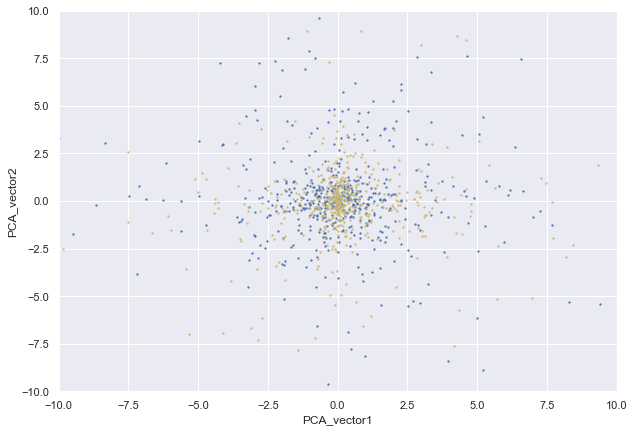

In [25]:
PCA_vector1_ALL = pcaTrain[y_train==0][0,:]
PCA_vector1_AML = pcaTrain[y_train==1][0,:]
PCA_vector2_ALL = pcaTrain[y_train==0][1,:]
PCA_vector2_AML = pcaTrain[y_train==1][1,:]

plt.figure(figsize=(10,7))
plt.scatter(PCA_vector1_ALL, PCA_vector2_ALL, color='b', alpha=0.8, s=2)
plt.scatter(PCA_vector1_AML, PCA_vector2_AML, color='y', alpha=0.8, s=2)
plt.xlabel('PCA_vector1')
plt.ylabel('PCA_vector2')
plt.ylim((-10, 10)) 
plt.xlim((-10, 10))
# plt.title('Plot showing distribution of vectors')
plt.show()

##### Answer 4.2:
By using a scatterplot of the top two PCA vectors towards eachother, you can often identify visually if there is a relationship to be found. This can often reveal clear relationships in the distribution, even though in the above example it is not as easy to see the relationship.


**4.3 Determine and report the variance explained in `X_train` based on the top 2 PCA vectors.  Determine and report how many PCA vectors are needed so that 90\% of the variability in the predictors is explained, and create a plot to illustrate this result (Hint: look at cumulative explained variability vs. number of PCA components used).  Select a reasonable value for the number of components that balances representativeness (of the predictors) with parsimony.**

In [40]:
# here is the variance explained:
print("Variance explained by the first component: {:.4f}".format(pca.explained_variance_ratio_[0]))
print("Variance explained by the second component: {:.4f}".format(pca.explained_variance_ratio_[1]))

threshold=0.9
for index, entry in enumerate(pca.explained_variance_ratio_):
    if np.cumsum(pca.explained_variance_ratio_)[index] > threshold: 
        over90 = index
        break
print('{} PCA vectors are needed to explain 90% of the variability'.format(over90))

Variance explained by the first component: 0.0646
Variance explained by the second component: 0.0493
223 PCA vectors are needed to explain 90% of the variability


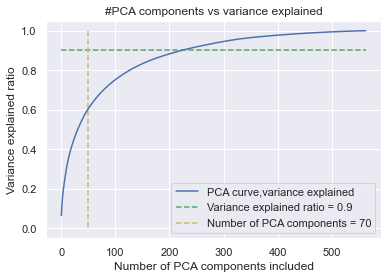

With 50 PCA components included we have a variance explained of 0.6062, and with 100 it is 0.7526


In [86]:
# Plotting the PCA components vs variance explained
x_pca_dummy = range(np.shape(pca.components_)[0])
plt.plot(x_pca_dummy, np.cumsum(pca.explained_variance_ratio_) , label='PCA curve,variance explained')
plt.hlines(0.9,xmin=np.min(x_pca_dummy),xmax=np.max(x_pca_dummy), color='g',linestyle='--', label='Variance explained ratio = 0.9')
plt.vlines(50,ymin=1,ymax=0, color='y',linestyle='--', label='Number of PCA components = 70')
plt.xlabel('Number of PCA components included')
plt.ylabel('Variance explained ratio')
plt.title('#PCA components vs variance explained')
plt.legend()
plt.show()

print('With 50 PCA components included we have a variance explained of {0:.4f}, and with 100 it is {1:.4f}'.format(np.cumsum(pca.explained_variance_ratio_)[50], np.cumsum(pca.explained_variance_ratio_)[100]))

##### Answer 4.3:
When choosing a number of components with parsimony, 50 seems like a reasonable number. With this number we explain about 60.6% of the variance, and if the number is doubled (to 100 components) we only explain about 15% more of the variance.


---

<div class='exercise'><b> Question 5 [10 pts]: Principal Components Regression (PCR) </b></div>

**5.1** Fit three separate Logistic Regression models using principal components as the predictors: (1) with just the first 2 PCA vectors, (2) with the number of component vectors you chose from 5.4 above, and (3) with the number of components that explain at least 90% of the variability in the predictor set. How do the classification accuracy values on both the training and test sets compare with these models?

**5.2** Use cross-validation to determine the best number of principal components. Try out the 3 values from the previous sub-part and optionally include other values as well. For the best performing model according to cross-validation, interpret what the model says about the relationship between `best_predictor` and `Cancer_type`.



### Answers

**5.1 Fit three separate Logistic Regression models using principal components as the predictors: (1) with just the first 2 PCA vectors, (2) with the number of component vectors you chose from 5.4 above, and (3) with the number of components that explain at least 90% of the variability in the predictor set. How do the classification accuracy values on both the training and test sets compare with these models?**

In [29]:
######
# your code here
######


*your answer here*


**5.2 Use cross-validation to determine the best number of principal components. Try out the 3 values from the previous sub-part and optionally include other values as well. For the best performing model according to cross-validation, interpret what the model says about the relationship between your `best_predictor` and `Cancer_type`**.

In [30]:
######
# your code here
######


* your answer here*

<div class='exercise'><b> Question 6 [15 pts]: Evaluating Classifiers </b></div>

**6.1**: Another way to evaluate models in a classification setting is through an Area-under-the-ROC-Curve (AUC). Briefly explain what the AUC and the ROC are trying to do and how this approach differs from evaluating models based on misclassification rate (as you have done thus far in this problem set).

**6.2** Evaluate the 'best' models (best based on test misclassification: if there is a tie, choose the 'simplest' model) from each class of classification models using AUC.  That is calculate AUC for the following models:
- the best logistic regression model, whether regularized or not (question 2)
- the best $k$-NN model (question 3)
- the best PCR model (question 5)

For the model with the best AUC, plot the ROC. Briefly interpret your plot.

**6.3** Based on AUC, is there one clear stand-out winner or are a lot of models similar in prediction?  If you were to predict real cancer patients, how would use these models to predict cancer type?

*See extra information about ALL and AML at the bottom of this notebook.*

### Answers

**6.1 Another way to evaluate models in a classification setting is through an Area-under-the-ROC-Curve (AUC). Briefly explain what the AUC and the ROC are trying to do and how this approach differs from evaluating models based on misclassification rate (as you have done thus far in this problem set).**

*your answer here*


**6.2 use AUC to evaluate the 'best' models (best based on test misclassification: if there is a tie, choose the 'simplest' model) from each class of classification models.  That is calculate AUC for the following models:**
- the best logistic regression model, whether regularized or not (question 2)
- the best $k$-NN model (question 3)
- the best PCR model (question 5)

**For the model with the best AUC, plot the ROC. Briefly interpret your plot.**



In [31]:
######
# your code here
######


*your answer here*

**6.3 Based on AUC, is there one clear stand-out winner or are a lot of models similar in prediction?  If you were to predict real cancer patients, how would use these models to predict cancer type?**

*your answer here*


<hr style="height:2pt">


**Additional Information**

Acute Lymphoblastic Leukemia (ALL):
- About 98% of children with ALL go into remission within weeks after starting treatment.
- About 90% of those children can be cured. Patients are considered cured after 10 years in remission.

Acute Myeloid Leukemia (AML):
- In general, children with AML are seen as lower risk than adults. 
- Around 85 to 90 percent of children with AML will go into remission after induction, according to the American Cancer Society. AML will return in some cases.  
- The five-year-survival-rate for children with AML is 60 to 70 percent.

<hr style="height:2pt">